# Интерполяция

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

### Входные данные

Население Беларуси
https://www.belstat.gov.by/en/

In [2]:
data = pd.read_excel('population.xlsx')
data.replace(',','', regex=True, inplace=True)

nodes  = np.array(data['Year'], dtype=np.float64)
values = np.array(data['Population'], dtype=np.float64)

data

,Year,Population
0,1950,7745000
1,1951,7765000
2,1952,7721000
3,1953,7690000
4,1954,7722000
...,...,...
69,2019,9429257
70,2020,9410259
71,2021,9349645
72,2022,9255524


### Определим норму и $\varepsilon$

In [3]:
epsilon = 1e-6

# "Кубическая" халявная норма вектора :)
def norm(x):
    return np.max(abs(x))

### Интерполяционный многочлен в форме Ньютона

In [4]:
def divided_diff(i, x, f):
    assert len(i) >= 1, 'Index array must not be empty'
    assert len(x) == len(f) == len(i), 'Arrays lengths mismatch'
    if len(i) == 1:
        return f[0]
    # Обобщим разность для одинаковых узлов
    if x[-1] == x[0]:
        return 0
    
    return (divided_diff(i[1:], x[1:], f[1:]) - divided_diff(i[:-1], x[:-1], f[:-1])) / (x[-1] - x[0])

class Newton:
    def __init__(self, x, f):
        assert len(x) == len(f), 'Arrays lengths mismatch'
        
        self.values = f
        self.nodes  = x
        self.coeffs = np.array([divided_diff(range(i), self.nodes[:i], self.values[:i]) for i in range(1, len(self.nodes) + 1)])
        
    def __call__(self, x):
        __res = 0
        for i in range(len(self.coeffs) - 1, 0, -1):
            __res = (__res + self.coeffs[i]) * (x - self.nodes[i - 1])
        return __res + self.coeffs[0]



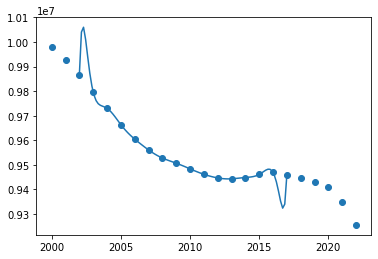

In [26]:
x = nodes[52:68]
f = values[52:68]

interp = Newton(x, f)
t = np.linspace(min(x), max(x), 100)
plt.plot(t, interp(t))

plt.scatter(nodes[50:73], values[50:73])

#

### Метод наименьших квадратов

### Сплайн-аппроксимация

#### Метод трехдиагональной прогонки

In [27]:
#
# Tridiagonal matrix algorithm
# See: https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
#
# [b c 0     ... 0][x0]     [d0]
# [a b c 0   ... 0][x1]     [d1]
# [0 a b c 0 ... 0][x2]   = [d2]
# [      ...      ][...]    [...]
# [0     ... 0 a b][xn-1]   [dn-1]
#
def tridiagonal(a, b, c, d):
    assert len(a) + 1 == len(b) == len(c) + 1 == len(d), 'Arrays lengths mismatch'
     
    __a = np.array(a, dtype = np.float64)
    __b = np.array(b, dtype = np.float64)
    __c = np.array(c, dtype = np.float64)
    __d = np.array(d, dtype = np.float64)
    
    #print(__a, __b, __c, __d)
    for i in range(1, len(__d)):
        __w = __a[i - 1] / __b[i - 1]
        __b[i] = __b[i] - __w * __c[i - 1]
        __d[i] = __d[i] - __w * __d[i - 1]

    __x = np.empty(len(__d), dtype = np.float64)
    __x[-1] = __d[-1] / __b[-1]
    for i in range(len(__d) - 2, -1, -1):
        __x[i] = (__d[i] - __c[i] * __x[i + 1]) / __b[i]

    # Test solution
    __test_matrix = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
    assert norm(np.matmul(__test_matrix, __x.T) - d) < epsilon, 'Tridiagonal method failed'
        
    return __x

In [28]:
#
# Cubic Spline interpolation
# See: https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation
#
class Spline:
    def __init__(self, x, f, lambda_0 = 1, mu_n = 1):
        assert len(x) == len(f), 'Arrays lengths mismatch'
        
        self.x = x
        self.f = f
        
        __diag = np.full(len(self.x), 2)
        __mu = np.empty(len(self.x) - 1)
        __mu.fill(0)
        for i in range(0, len(self.x) - 2):
            __mu[i] = (self.x[i+1] - self.x[i])/(self.x[i+2] - self.x[i])
        __mu[-1] = mu_n # Boundary conditions

        __lambda = np.empty(len(self.x) - 1)
        __lambda.fill(0)
        __lambda[1:] = 1 - __mu[:-1]
        __lambda[0] = lambda_0 # Boundary conditions
        
        __d = np.empty(len(self.x))
        for i in range(0, len(self.x)):
            jj = (max(0, i - 1), i, min(len(self.x) - 1, i + 1))
            __d[i] = 6 * divided_diff(jj, np.take(self.x, jj), np.take(self.f, jj))
        
        self.M = tridiagonal(__mu, __diag, __lambda, __d)
        
    def __call__(self, x_arr):
        __res = np.empty(len(x_arr))
        for j, x in enumerate(x_arr):
            i = np.argmax(self.x > x)
            hi = (self.x[i] - self.x[i-1])
            __res[j] = self.M[i-1] * (self.x[i] - x)**3 / (6 * hi) \
                       + self.M[i] * (x - self.x[i-1])**3 / (6 * hi) \
                       + (self.f[i-1] - self.M[i-1] * hi**2 / 6) * (self.x[i] - x) / hi \
                       + (self.f[i] - self.M[i] * hi**2 / 6) * (x - self.x[i-1]) / hi
        return __res

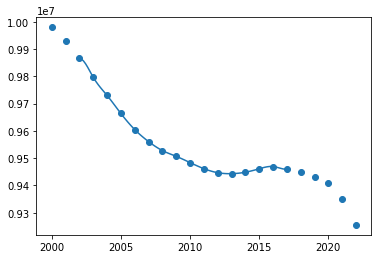

In [29]:
x = nodes[52:68]
f = values[52:68]

interp = Spline(x, f)
t = np.linspace(min(x), max(x), 100)
plt.plot(t, interp(t))

plt.scatter(nodes[50:73], values[50:73])
